# Stroke Risk Prediction

We are interested in finding the factors that make a patient more likely to suffer a stroke. We are going to study different variables to explore the relationship and differences among biological and  environmental factors and stroke incidence.

Our data focuses on over 5000 patients. This project offers exciting possibilities for prediction analysis and hopefully actionable insights to reduce strokes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pointbiserialr
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

## Conclussion

##### Data Cleaning
- We have check for duplicates 
- We have identified missing BMI and smoking_status information
- We have dummified the variables to manipulate the data in our models later on

##### Exploratory Data Analysis
- We could see in charts that both bmi and average glucose had a positive relationship with suffering a stroke.
- By dividing the population in different subcategories (for example, underweight, obese, etc.) we were able to show a big difference in the stroke rate.
- Age also showed a clear relationship with stroke, with virtually no patients younger than 30 suffering from it.

##### Hypothesis
- We tested our null hypothesis to see wether or not the patient median age was different between those who suffered a stroke and those who didn't. We rejected the null hypothesis.

- We also test our null hypothesis to see wether or not the patient mean BMI was different between those who suffered a stroke and those who didn't. We rejected the null hypothesis.

##### ML models
- We assigned all children under 10 as never smoked. The rest of the missing values were assigned by random forest.
- We assigned the bmi missing values by random forest too, which resulted in a mean higher than the overall population mean.
- We tuned two different models, logistic regression and random forest. Due to it's simplicity and good recall rate relative to f1-score, we prefer the logistic regression model.


#### How to improve our analysis
- It would have been interesteing to include dummy variables such as obese, overweight, etc. to explore how the models perform

- Also, with more try we would have tried and tuned gradient boosting

## Data Cleaning

In [2]:
stroke_prediction_df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
stroke_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
stroke_prediction_df = stroke_prediction_df.drop(columns=['id'])

In [5]:
stroke_prediction_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

All of the null values in the dataset correspond to the bmi column. Let's explore to see if there is an undergoing cause

In [6]:
object__type_variables = stroke_prediction_df.select_dtypes(include='object').columns

for column in object__type_variables:
    unique_values = stroke_prediction_df[column].unique()
    print(f"Unique values in '{column}':")
    print(unique_values)
    print("-" * 50)

Unique values in 'gender':
['Male' 'Female' 'Other']
--------------------------------------------------
Unique values in 'ever_married':
['Yes' 'No']
--------------------------------------------------
Unique values in 'work_type':
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
--------------------------------------------------
Unique values in 'Residence_type':
['Urban' 'Rural']
--------------------------------------------------
Unique values in 'smoking_status':
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
--------------------------------------------------


Luckily for us, 'Unknown' only appears in the smoking_status variable, however we have noticed the "other" category in gender. Also "children" in work_type, which probably refers to the age of the patient.

In [7]:
unknown_count = stroke_prediction_df['smoking_status'].value_counts().get('Unknown', 0)

print(f"Number of 'Unknown' values in the smoking_status column: {unknown_count}")

Number of 'Unknown' values in the smoking_status column: 1544


The number of 'Unknown' values in the smoking_status variable represents around 30% of our data, and based on published research, is reasonably to expect smoking to be a stroke predictor. We would explore different options to handle the missing data.

In [8]:
unknown_count = stroke_prediction_df['gender'].value_counts().get('Other', 0)

print(f"Number of 'other' values in the gender column: {unknown_count}")

Number of 'other' values in the gender column: 1


We are going to treat the entry described as 'other' in the gender column as "female", since it's just a single data point we can't extrapolate any information for non-binary people and it won't affect our model.

### Make data binary 

We want to make the data binary for our ML models, but also to check beforehand any possibility of a high correlation between not having information regarding smoking status and other features.

#### Dummifying the variables

In [9]:
stroke_prediction_df['is_Male'] = (stroke_prediction_df['gender'] == 'Male').astype(int)

stroke_prediction_df = pd.get_dummies(stroke_prediction_df, columns=['ever_married', 'Residence_type'], drop_first=True)

stroke_prediction_df = pd.get_dummies(stroke_prediction_df, columns=['work_type', 'smoking_status'], drop_first=False)

In [10]:
stroke_prediction_df = stroke_prediction_df.drop(columns=['gender'])

In [11]:
stroke_prediction_df.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_Male,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,True,True,False,False,True,False,False,False,True,False,False
1,61.0,0,0,202.21,NaN,1,0,True,False,False,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,1,True,False,False,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,0,True,True,False,False,True,False,False,False,False,False,True
4,79.0,1,0,174.12,24.0,1,0,True,False,False,False,False,True,False,False,False,True,False


#### Checking for duplicate values

In [12]:
num_duplicates = stroke_prediction_df.duplicated().sum()

if num_duplicates == 0:
    print("There are no duplicates")
else:
    print(f"Number of duplicate rows: {num_duplicates}")

There are no duplicates


## Exploratory Data Analysis

First we will split the data to avoid data leakage now, and proceed to explore the type of population and relationships amongs the different variables we have.

In [13]:
# TODO Maybe need to stratify for stroke
train_data, test_data = train_test_split(stroke_prediction_df, test_size=0.2, random_state=42, stratify=stroke_prediction_df['stroke'])

train_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_Male,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
845,48.0,0,0,69.21,33.1,0,0,True,True,False,False,True,False,False,False,False,True,False
3744,15.0,0,0,122.25,21.0,0,1,False,False,False,False,True,False,False,False,False,True,False
4183,67.0,0,0,110.42,24.9,0,0,True,False,False,False,False,True,False,False,False,True,False
3409,44.0,0,0,65.41,24.8,0,1,True,True,False,False,True,False,False,False,False,False,True
284,14.0,0,0,82.34,31.6,0,1,False,True,True,False,False,False,False,True,False,False,False


In [14]:
train_data[['age', 'avg_glucose_level', 'bmi']].describe()

,age,avg_glucose_level,bmi
count,4088.000000,4088.000000,3918.000000
mean,43.353288,106.317167,28.922180
std,22.596816,45.259652,7.928378
min,0.080000,55.120000,10.300000
25%,26.000000,77.312500,23.600000
50%,45.000000,91.945000,28.000000
75%,61.000000,114.197500,33.100000
max,82.000000,271.740000,97.600000


We ca see that the age ranges between 0 and 82, with some possible high outliers in the average glucose levels and bmi but within being believable values

#### Population analysis

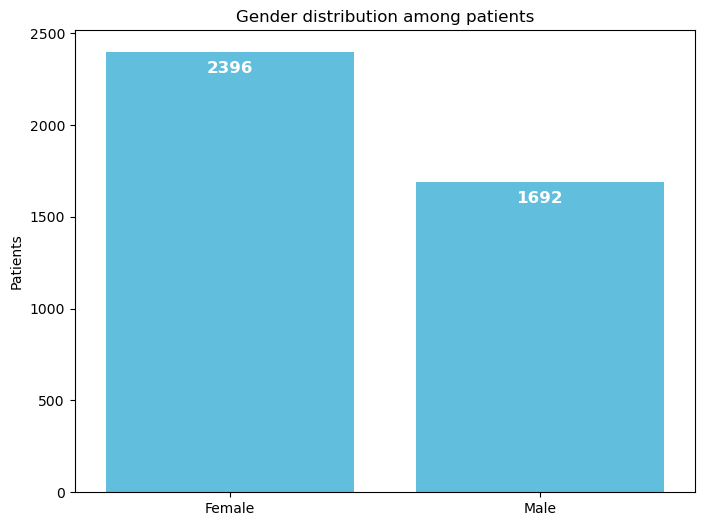

In [15]:
palette = ['#4CC9F0']

train_data_gender = train_data.copy()
train_data_gender['gender'] = train_data_gender['is_Male'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='gender', data=train_data_gender, palette=palette)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, -12), textcoords='offset points',
                fontweight='semibold', color='white', fontsize=12)

plt.ylabel('Patients')
plt.xlabel('')
plt.title("Gender distribution among patients")

plt.show()

We can see that we have over 40% more women than men in the data, which we might need to adjust for our predictive model

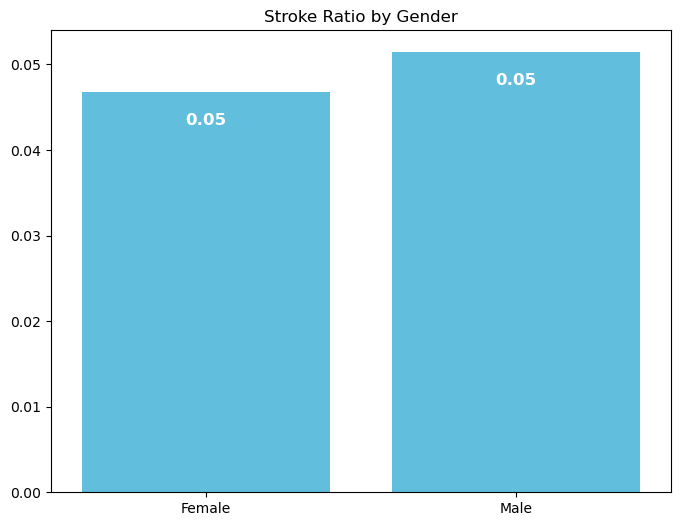

In [16]:

stroke_ratio = train_data_gender.groupby('gender')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='gender', y='stroke', data=stroke_ratio, palette=palette)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, -20), textcoords='offset points',
                fontweight='semibold', color='white', fontsize=12)

plt.ylabel('')
plt.xlabel('')
plt.title("Stroke Ratio by Gender")

plt.show()

In our data, the stroke ratio is the same in both genders. Perhaps when adjusting for other factors we can explore if gender is a stroke predictor, but at the moment that seems unlikely.

In [17]:
def plot_stroke_ratio(data, columns, labels, target, title, palette, padding, font):
    ratio = data[columns + [target]].melt(id_vars=target, var_name='category')
    ratio = ratio[ratio['value'] == 1]
    ratio = ratio.groupby('category')[target].mean().reset_index()
    ratio['category'] = ratio['category'].map(labels)

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='category', y=target, data=ratio, palette=palette)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, padding), textcoords='offset points', 
                    fontweight='semibold', color=font, fontsize=12)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title)
    plt.show()

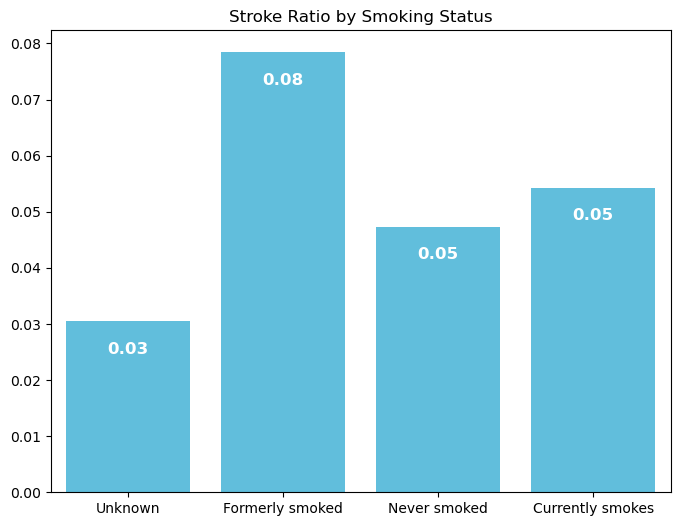

In [18]:
smoking_status_columns = ['smoking_status_Unknown',
                          'smoking_status_formerly smoked', 
                          'smoking_status_never smoked', 
                          'smoking_status_smokes']
smoking_status_labels = {
    'smoking_status_Unknown': 'Unknown',
    'smoking_status_formerly smoked': 'Formerly smoked',
    'smoking_status_never smoked': 'Never smoked',
    'smoking_status_smokes': 'Currently smokes'
}

plot_stroke_ratio(train_data, smoking_status_columns, smoking_status_labels, 'stroke', "Stroke Ratio by Smoking Status", palette, -20, 'white')


There are more strokes among those who used to smoke compared with those who currently smokes. If smoking has a positive impact in the probability of having a stroke, this could be explained by patients who quit smoking being at higher risk than those who currently smoke, for example. 

#### Exploring missing smoking data

In [19]:
columns_without_smoking_status = stroke_prediction_df.drop(columns=['smoking_status_formerly smoked', 
                                                                    'smoking_status_never smoked', 'smoking_status_smokes']).columns
filtered_df = stroke_prediction_df[columns_without_smoking_status]

correlation_matrix = filtered_df.corr()

correlation_with_unknown = correlation_matrix['smoking_status_Unknown'].sort_values(ascending=False)
print(correlation_with_unknown)

smoking_status_Unknown     1.000000
work_type_children         0.512743
is_Male                    0.059658
work_type_Never_worked     0.008804
Residence_type_Urban      -0.002036
stroke                    -0.055892
heart_disease             -0.066731
avg_glucose_level         -0.095131
work_type_Govt_job        -0.097418
work_type_Self-employed   -0.106250
hypertension              -0.141501
work_type_Private         -0.210013
bmi                       -0.270340
ever_married_Yes          -0.332081
age                       -0.378231
Name: smoking_status_Unknown, dtype: float64


*Note: We are using Pearson correlation here even though most data is binary, since this is just a quick way to see if we are missing the data for a particular group. Interestengly, those that don't work due to being children represent around half of the data missing in the smoking variable. This could be for a number of reasons, such as doctors not asking children about smoking habits as frequently as they do to adults, or different standards in children hospitals when collecting data.

#### Exploring the children in the data

We would like to know what age is referred to as children, and also check if the children might have been selected for a particular risk of stroke.

In [20]:
children_df = stroke_prediction_df[stroke_prediction_df['work_type_children'] == True]
min_age = children_df['age'].min()
max_age = children_df['age'].max()
print(f"Age range for work_type 'children': {min_age} to {max_age}")

Age range for work_type 'children': 0.08 to 16.0


We consider patients as "children" in work_type up to 16 years old.

In [21]:
def calculate_smoking_status(df, age_range, smoking_status_columns):
    age_filtered_df = df[(df['age'] >= age_range[0]) & (df['age'] <= age_range[1])]
    
    smoking_status_counts = age_filtered_df[smoking_status_columns].sum()
    
    smoking_status_percentages = (age_filtered_df[smoking_status_columns].mean() * 100)
    
    result_df = pd.DataFrame({
        'Count': smoking_status_counts,
        'Percentage': smoking_status_percentages
    })
    
    print(f"Smoking status for age range {age_range[0]} to {age_range[1]} years old:")
    print(result_df)
    print("\n")

age_ranges = [(0, 9), (10, 16), (17, 100)]

for age_range in age_ranges:
    calculate_smoking_status(stroke_prediction_df, age_range, smoking_status_columns)

Smoking status for age range 0 to 9 years old:
                                Count  Percentage
smoking_status_Unknown            472       100.0
smoking_status_formerly smoked      0         0.0
smoking_status_never smoked         0         0.0
smoking_status_smokes               0         0.0


Smoking status for age range 10 to 16 years old:
                                Count  Percentage
smoking_status_Unknown            185   57.098765
smoking_status_formerly smoked     21    6.481481
smoking_status_never smoked       113   34.876543
smoking_status_smokes               5    1.543210


Smoking status for age range 17 to 100 years old:
                                Count  Percentage
smoking_status_Unknown            887   20.560964
smoking_status_formerly smoked    864   20.027816
smoking_status_never smoked      1779   41.237830
smoking_status_smokes             784   18.173389




We can see that from children under 10 years old, we basically have no data regarding the smoking status. This is not as simmple as just changing the data to 'never_smoked" and requires careful considerations, since children can be passive smokers (even before they are born) and can also be active smokers before they turn 10. We could potentially try and conver this data to never_smoked. 

However, for those children between 10 and 16, inferring that becomes riskier. Excluding those marked as 'Unknown', almost 20% reported to have smoked (currently or in the past). However, we can expect that to be biased, since there is probably a stronger incentive to report the anormality (in this case, children smoking).

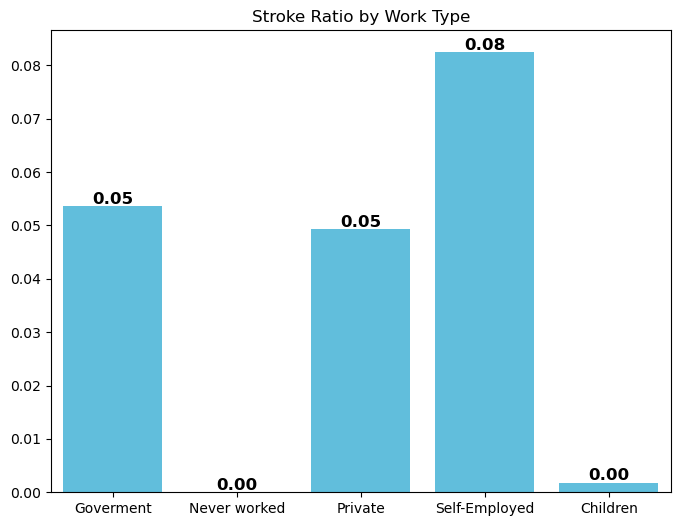

In [22]:
work_type_columns = ['work_type_Never_worked', 'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed', 'work_type_children']
work_type_labels = {
    'work_type_Govt_job': 'Goverment',
    'work_type_Never_worked': 'Never worked',
    'work_type_Private': 'Private',
    'work_type_Self-employed': 'Self-Employed',
    'work_type_children': 'Children'
}

plot_stroke_ratio(train_data, work_type_columns, work_type_labels, 'stroke', "Stroke Ratio by Work Type", palette, 5, 'black')

We can see that work type children from the data aren't particularly prone to strokes, so we can expect a lower rate of smoking that in the adult population.

Work type children has a lowered ratio than the other working groups, except "never worked". We are interested if these might be related to age and work_type_children is just 100% dependent on age.

In [23]:
filtered_data = train_data[(train_data['age'] >= 10) & (train_data['age'] <= 16)]

work_distribution = filtered_data[work_type_columns].sum()

work_distribution.index = work_distribution.index.map(work_type_labels)

print("Work distribution among individuals aged 10-16:")
print(work_distribution)

Work distribution among individuals aged 10-16:
Never worked       6
Goverment          2
Private           64
Self-Employed      4
Children         171
dtype: int64


Interestingly, over 30% of the children between 10 and 16 aren't assigned work_type_children.

#### Other binary variables

In [24]:
def create_contingency_table(data, variable, target):
    contingency_table = data.groupby(variable).agg(
        total_count=pd.NamedAgg(column=target, aggfunc='count'),
        stroke_cases=pd.NamedAgg(column=target, aggfunc='sum')
    ).reset_index()
    contingency_table['stroke_ratio'] = contingency_table['stroke_cases'] / contingency_table['total_count']
    return contingency_table

def format_value(value):
    if isinstance(value, float):
        value_str = f"{value:.2f}" 
        if value_str.endswith(".00"): 
            return value_str.rstrip("0").rstrip(".")  
        return value_str  
    return value

variables = ['hypertension', 'heart_disease', 'ever_married_Yes', 'Residence_type_Urban']

for var in variables:
    table = create_contingency_table(train_data, var, 'stroke')
    table = table.applymap(format_value)
    print(f"Contingency Table for {var}:\n")
    print(tabulate(table, headers='keys', tablefmt='pretty'))
    print("\n")

Contingency Table for hypertension:

+---+--------------+-------------+--------------+--------------+
|   | hypertension | total_count | stroke_cases | stroke_ratio |
+---+--------------+-------------+--------------+--------------+
| 0 |      0       |    3691     |     145      |     0.04     |
| 1 |      1       |     397     |      54      |     0.14     |
+---+--------------+-------------+--------------+--------------+


Contingency Table for heart_disease:

+---+---------------+-------------+--------------+--------------+
|   | heart_disease | total_count | stroke_cases | stroke_ratio |
+---+---------------+-------------+--------------+--------------+
| 0 |       0       |    3867     |     163      |     0.04     |
| 1 |       1       |     221     |      36      |     0.16     |
+---+---------------+-------------+--------------+--------------+


Contingency Table for ever_married_Yes:

+---+------------------+-------------+--------------+--------------+
|   | ever_married_Yes | 

Heart disease incidence is rare among patients, with only around 4% of them reporting having a heart disease but with a high stroke ratio,with 16% of the patients suffering a stroke, followed by those with hypertension with a 14% ratio. These both seem likely to be stroke predictors in our model.

People who ever married have a higher stroke ratio than those who hadn't (this is probably explain by the age variable, since people who ever have been married are older than those who hadn't).

Patients that live in rural or urban residences seem to have a similar number of stroke cases.

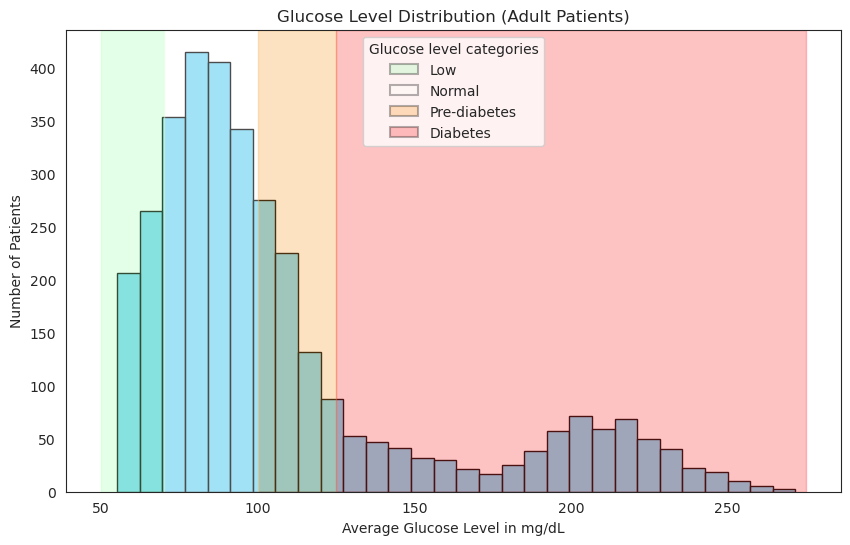

In [25]:
sns.set_style("white")

plt.figure(figsize=(10, 6))

train_data_adults = train_data[train_data['age'] >= 18]
ax = sns.histplot(train_data_adults['avg_glucose_level'], bins=30,
                  kde=False, color='#4CC9F0', edgecolor='black')

plt.axvspan(50, 70, color='#A6FFB0', alpha=0.3, label='Low')
plt.axvspan(70, 100, color='#FFFFFF', alpha=0.3, label='Normal')
plt.axvspan(100, 125, color='#FBA038', alpha=0.3, label='Pre-diabetes')
plt.axvspan(125, 275, color='#FB3838', alpha=0.3, label='Diabetes')

plt.xlabel('Average Glucose Level in mg/dL')
plt.ylabel('Number of Patients')
plt.title('Glucose Level Distribution (Adult Patients)')

legend = plt.legend(title='Glucose level categories')

for handle in legend.legend_handles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1.5)

plt.show()

We have used the categories given by the WHO standardized for people 18 years or older. We can observe that glucose levels are high skew, with a long tail of very high glucose patients and a mode where the normal levels are located, as we could expect.

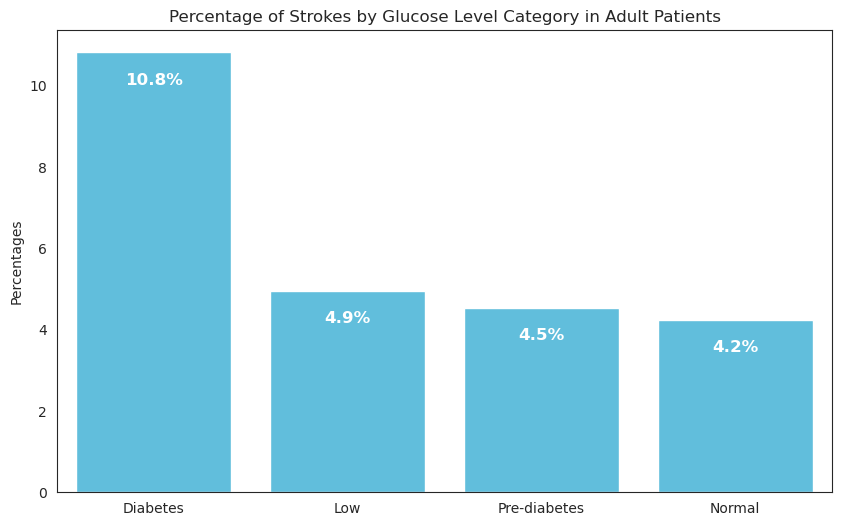

In [26]:
train_data_adults = train_data[train_data['age'] >= 18].copy()

def categorize_glucose_level(glucose_level):
    if glucose_level < 70:
        return 'Low'
    elif 70 <= glucose_level < 100:
        return 'Normal'
    elif 100 <= glucose_level < 125:
        return 'Pre-diabetes'
    else:
        return 'Diabetes'

train_data_adults.loc[:, 'glucose_category'] = train_data_adults['avg_glucose_level'].apply(categorize_glucose_level)

stroke_percentage = train_data_adults.groupby('glucose_category')['stroke'].mean() * 100

stroke_percentage = stroke_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=stroke_percentage.index, y=stroke_percentage.values, palette=palette)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, -20), textcoords='offset points',
                fontweight='semibold', color='white', fontsize=12)

plt.xlabel('')
plt.ylabel('Percentages')
plt.title('Percentage of Strokes by Glucose Level Category in Adult Patients')

plt.show()

Adults on the Diabetes category have the highest rate of strokes compared with all the other groups, followed by the patients in the Pre-Diabetes category. Interestingly, those with a lower than normal glucose levels have even fewer strokes than those with the 'normal' levels (generally the recommended range).

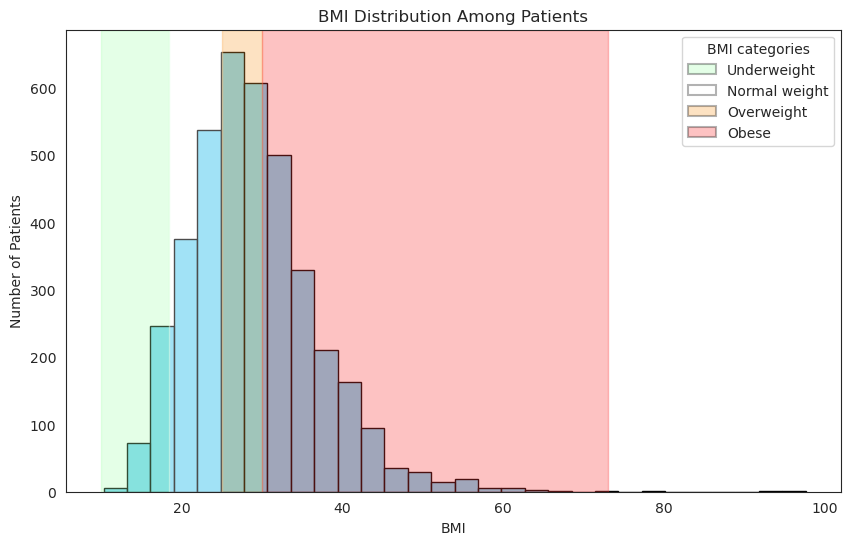

In [27]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(train_data['bmi'], bins=30, kde=False, color='#4CC9F0', edgecolor='black')
plt.axvspan(10, 18.5, color='#A6FFB0', alpha=0.3, label='Underweight')
plt.axvspan(18.5, 25, color='#FFFFFF', alpha=0.3, label='Normal weight')
plt.axvspan(25, 30, color='#FBA038', alpha=0.3, label='Overweight')
plt.axvspan(30, 73, color='#FB3838', alpha=0.3, label='Obese')

plt.xlabel('BMI')
plt.ylabel('Number of Patients')
plt.title('BMI Distribution Among Patients')

legend = plt.legend(title='BMI categories')

for handle in legend.legend_handles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1.5)

plt.show()

Regarding the BMI distribution, we can see that the data follows a mostly normal distribution slightly right-skewed, with the peak at the Overweight/Pre-obese category.

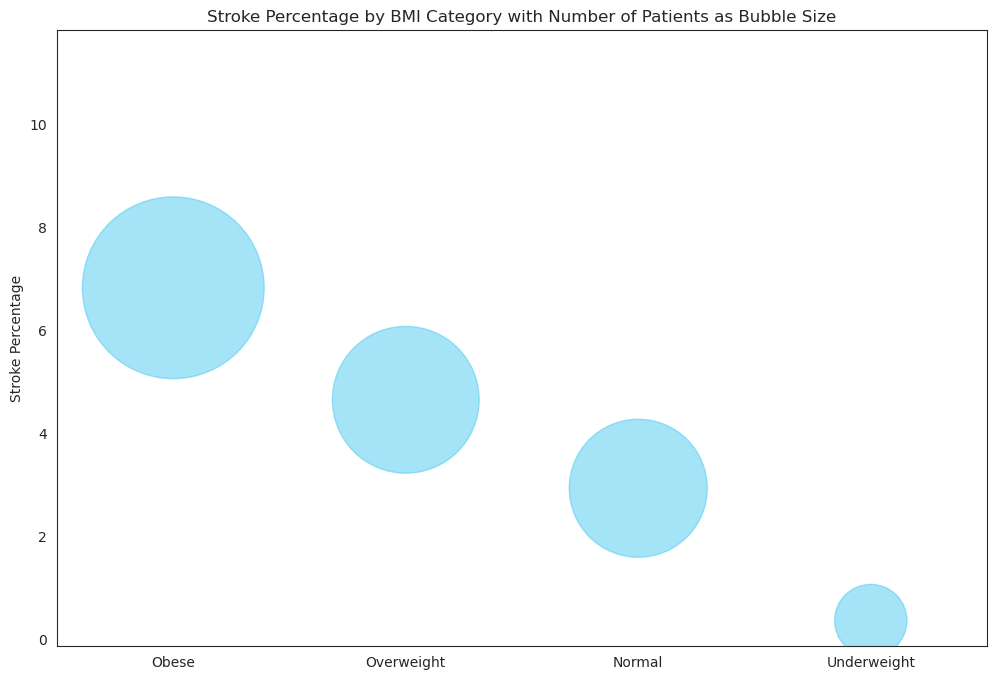

In [28]:
def categorize_bmi_level(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Create a new DataFrame
train_data_bmicategory = train_data.copy()
train_data_bmicategory['bmi_category'] = train_data_bmicategory['bmi'].apply(categorize_bmi_level)

category_order = ['Obese', 'Overweight', 'Normal', 'Underweight']
train_data_bmicategory['bmi_category'] = pd.Categorical(train_data_bmicategory['bmi_category'], categories=category_order, ordered=True)

stroke_stats = train_data_bmicategory.groupby('bmi_category').agg(
    stroke_percentage=('stroke', 'mean'),
    count=('stroke', 'size')
).reset_index()
stroke_stats['stroke_percentage'] = stroke_stats['stroke_percentage'] * 100

stroke_stats = stroke_stats.sort_values('bmi_category')

plt.figure(figsize=(12, 8))
bubble_chart = plt.scatter(
    x=stroke_stats['bmi_category'], 
    y=stroke_stats['stroke_percentage'], 
    s=stroke_stats['count'] * 10,  
    alpha=0.5, 
    c='#4CC9F0',  
)

plt.ylabel('Stroke Percentage')
plt.title('Stroke Percentage by BMI Category with Number of Patients as Bubble Size')

categories = stroke_stats['bmi_category']
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=0)

plt.xlim(-0.5, len(categories) - 0.5)
plt.ylim(stroke_stats['stroke_percentage'].min() - 0.5, stroke_stats['stroke_percentage'].max() + 5)

plt.show()

Once more, the obese and overweight groups have the most strokes. We also can clearly see that the stroke percentage of the underweight population is more than 6 times smaller than of those in the normal weight according to BMI.

#### Including stroke rate and size of NaNs in BMI

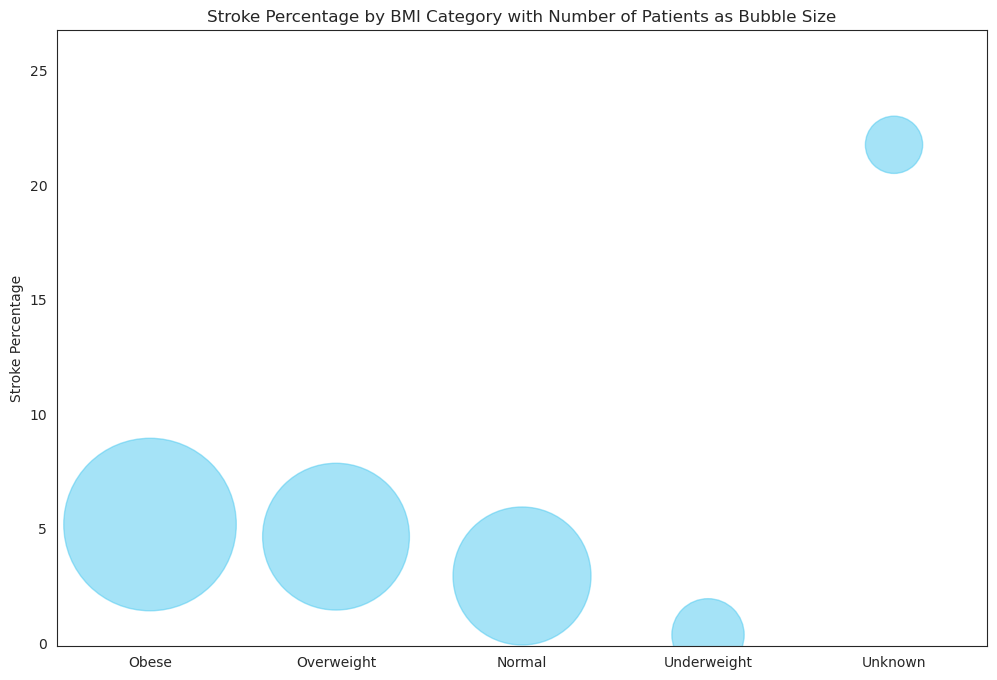

In [29]:
def categorize_bmi_level(bmi):
    if pd.isna(bmi):
        return 'Unknown'
    elif bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Create a new DataFrame
train_data_bmicategory = train_data.copy()
train_data_bmicategory['bmi_category'] = train_data_bmicategory['bmi'].apply(categorize_bmi_level)

category_order = ['Obese', 'Overweight', 'Normal', 'Underweight', 'Unknown']
train_data_bmicategory['bmi_category'] = pd.Categorical(train_data_bmicategory['bmi_category'], categories=category_order, ordered=True)

stroke_stats = train_data_bmicategory.groupby('bmi_category').agg(
    stroke_percentage=('stroke', 'mean'),
    count=('stroke', 'size')
).reset_index()
stroke_stats['stroke_percentage'] = stroke_stats['stroke_percentage'] * 100

stroke_stats = stroke_stats.sort_values('bmi_category')

plt.figure(figsize=(12, 8))
bubble_chart = plt.scatter(
    x=stroke_stats['bmi_category'], 
    y=stroke_stats['stroke_percentage'], 
    s=stroke_stats['count'] * 10,  
    alpha=0.5, 
    c='#4CC9F0',  
)

plt.ylabel('Stroke Percentage')
plt.title('Stroke Percentage by BMI Category with Number of Patients as Bubble Size')

categories = stroke_stats['bmi_category']
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=0)

plt.xlim(-0.5, len(categories) - 0.5)
plt.ylim(stroke_stats['stroke_percentage'].min() - 0.5, stroke_stats['stroke_percentage'].max() + 5)

plt.show()

The stroke rate among the unknown BMI values is extremely high, so handling the missing value assigning a mean seems unreasonable.

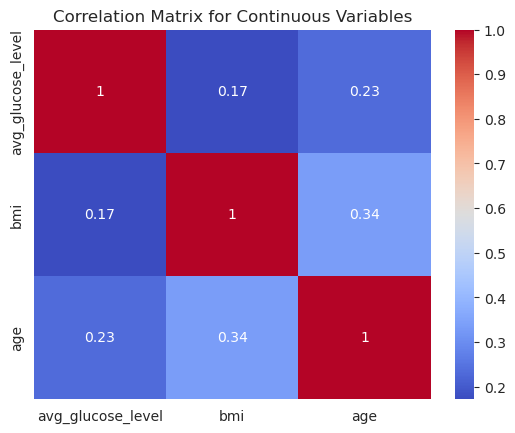

In [30]:
corr_continuous = train_data[['avg_glucose_level', 'bmi', 'age']].corr()
sns.heatmap(corr_continuous, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Continuous Variables')
plt.show()


The correlation matrix shows that both bmi and average glucose deteriorate with age, highlighting that age and bmi have a moderate positive correlation, with both age and glucose, and bmi and glucose presenting a weak positive correlatoin 

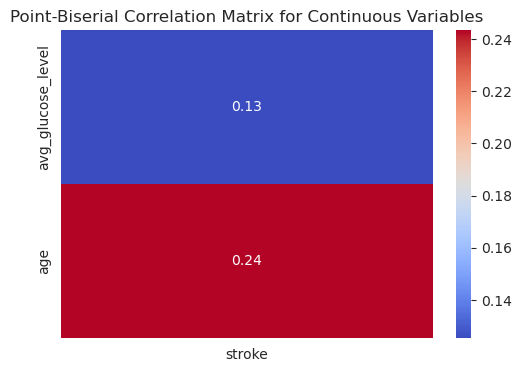

In [31]:
def point_biserial_corr(x, y):
    return pointbiserialr(x, y)[0]

continuous_columns = ['avg_glucose_level', 'age']

corr_matrix = pd.DataFrame(index=continuous_columns, columns=['stroke'])

for col in continuous_columns:
    corr_matrix.loc[col, 'stroke'] = point_biserial_corr(train_data[col], train_data['stroke'])

corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Point-Biserial Correlation Matrix for Continuous Variables')
plt.show()

Age has a moderate positive relationship with strokes, average glucose a weak positive relationship.

#### Age and Glucose as possible predictors

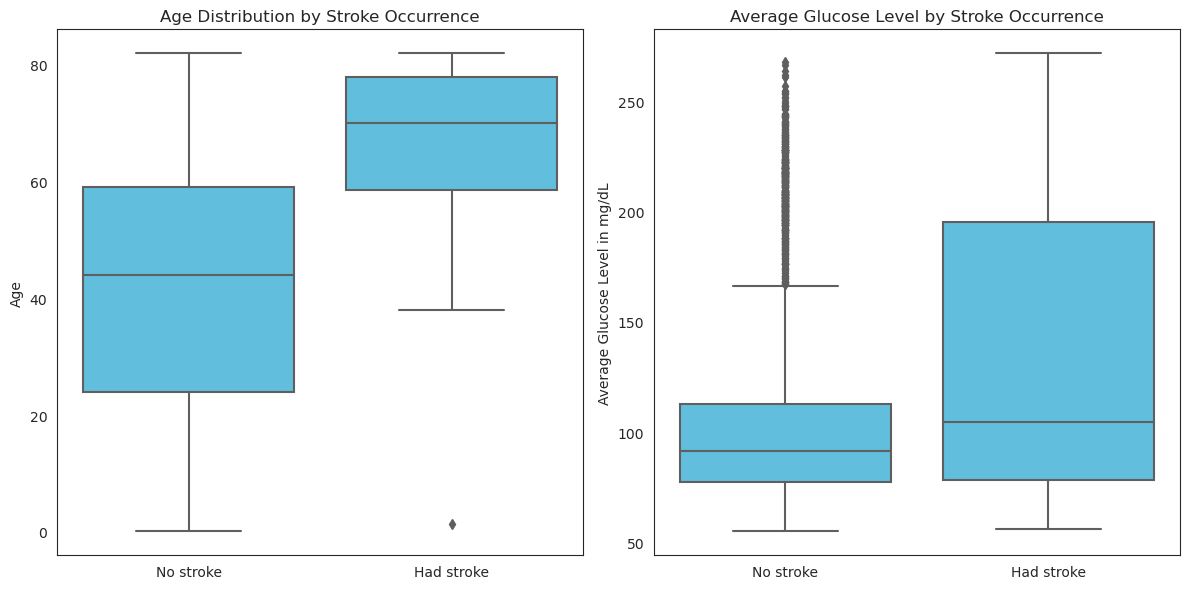

In [32]:
train_data_copy = train_data.copy()
train_data_copy['stroke_label'] = train_data_copy['stroke'].map({0: 'No stroke', 1: 'Had stroke'})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='stroke_label', y='age', data=train_data_copy, ax=axes[0], palette=palette)
axes[0].set_title('Age Distribution by Stroke Occurrence')
axes[0].set_xlabel('')
axes[0].set_ylabel('Age')

sns.boxplot(x='stroke_label', y='avg_glucose_level', data=train_data_copy, ax=axes[1], palette=palette)
axes[1].set_title('Average Glucose Level by Stroke Occurrence')
axes[1].set_xlabel('')
axes[1].set_ylabel('Average Glucose Level in mg/dL')

plt.tight_layout()
plt.show()

As we would expect, the median age of people who suffer a stroke is significantly higher than those who don't.

Regarding the glucose levels, the median is also higher in those who suffer a stroke. However, there are a lot of high outliers in the group of patients that didn't suffer a stroke.

#### Age and BMI combined

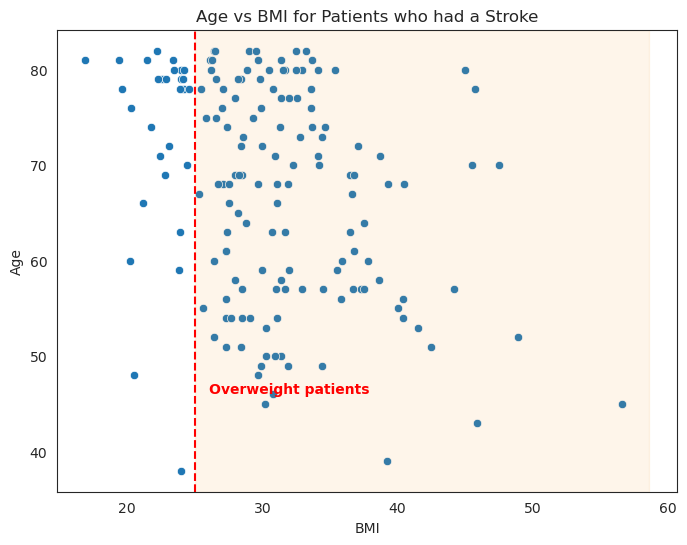

In [33]:
stroke_patients = train_data[train_data['stroke'] == 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='bmi', y='age', data=stroke_patients)

plt.axvline(x=25, color='red', linestyle='--')
plt.text(32, plt.ylim()[0] + 10, 'Overweight patients', color='red', ha='center', va='bottom', fontweight='bold')
plt.axvspan(25, plt.xlim()[1], color='#FBA038', alpha=0.1)

plt.xlabel('BMI')
plt.ylabel('Age')
plt.title('Age vs BMI for Patients who had a Stroke')
plt.show()


This plot shows the relationships between age and BMI and the stroke incidence among patients. We can clearly see that there is only an outlier as the only case of stroke for those aged under 30. If, as we suspect, bmi positively impacts the chance of having a stroke, we would expect those with very high bmi to die younger than the average. 

We can notice that most stroke happens to patients that are overweight according to the bmi, but we need to keep in mind that most of our patients are overweight too. However, the median is at 28.5, so being overweight seems to be an strong indicator.

### Hypothesis: Median age is equal between those who have suffer a stroke and those who have not

We are interested in exploring if age is an indicator of having a stroke. Therefore:
- H0: There is no difference between the median age of patients who suffered a stroke and those who haven't
- H1: There is a difference between the median age of patients who suffered a stroke and those who haven't

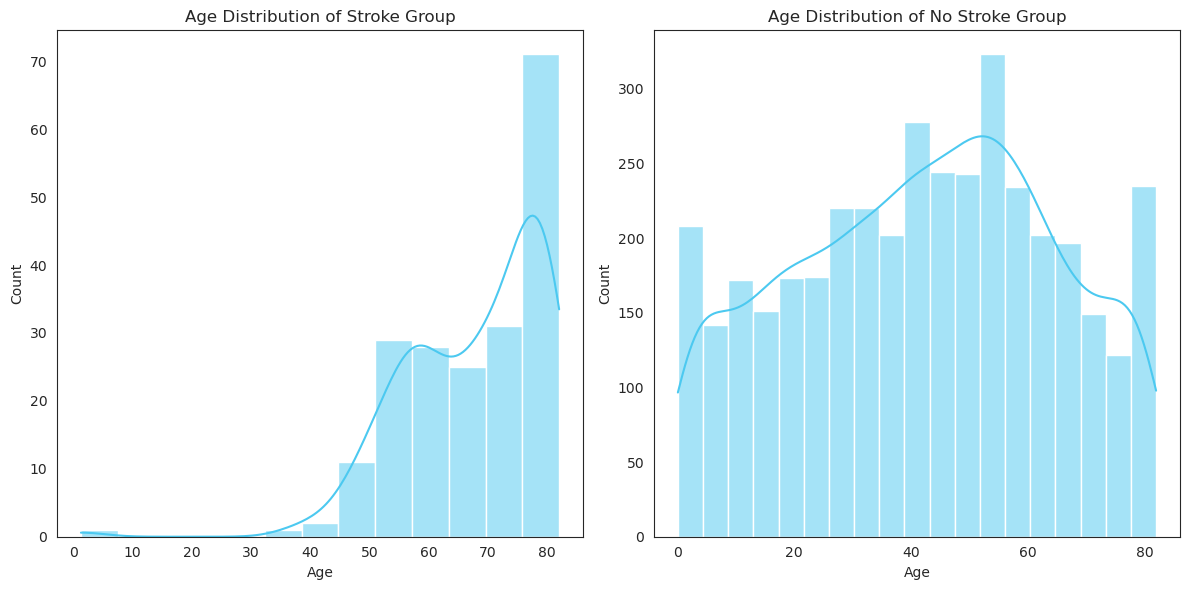


Levene's test for homogeneity of variance:
Statistic: 111.1431
p-value: 0.0000


In [34]:

stroke_group = train_data[train_data['stroke'] == 1]['age']
no_stroke_group = train_data[train_data['stroke'] == 0]['age']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(stroke_group, kde=True, color='#4CC9F0')
plt.title('Age Distribution of Stroke Group')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(no_stroke_group, kde=True, color='#4CC9F0')
plt.title('Age Distribution of No Stroke Group')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

levene_test = stats.levene(stroke_group, no_stroke_group)

print("\nLevene's test for homogeneity of variance:")
print(f'Statistic: {levene_test.statistic:.4f}')
print(f'p-value: {levene_test.pvalue:.4f}')

We can clearly see in the histograms that the age from patients who suffered stroke is not normal, but heavily left skew,  with the mode at highest values. Regarding the group of patients who didn't have a stroke, there are appears to be a mode at the extreme low values, and two others at the mid-high (around 55 years)and in the 70s.



In [35]:
welch_ttest = stats.ttest_ind(stroke_group, no_stroke_group, equal_var=False)

# Print results
print("Welch's t-test results:")
print(f't-statistic: {welch_ttest.statistic:.4f}')
print(f'p-value: {welch_ttest.pvalue:.4f}')

Welch's t-test results:
t-statistic: 27.9311
p-value: 0.0000


Given the inequal variances and lack of normality, we did Welch's t-test, with a T-statistic of 27.93 to 2 d. p. This means that there is a very strong statistical difference between the two groups. The p-value is much smaller than our significance level of 0.05, so we can reject the null hypothesis that there is no difference between the groups.

### Hypothesis: Mean BMI is equal between those who have suffer a stroke and those who have not

We are interested in exploring if average glucose is an indicator of having a stroke. Therefore:
- H0: There is no difference between the mean bmi of patients who suffered a stroke and those who haven't
- H1: There is a difference between the bmi of patients who suffered a stroke and those who haven't

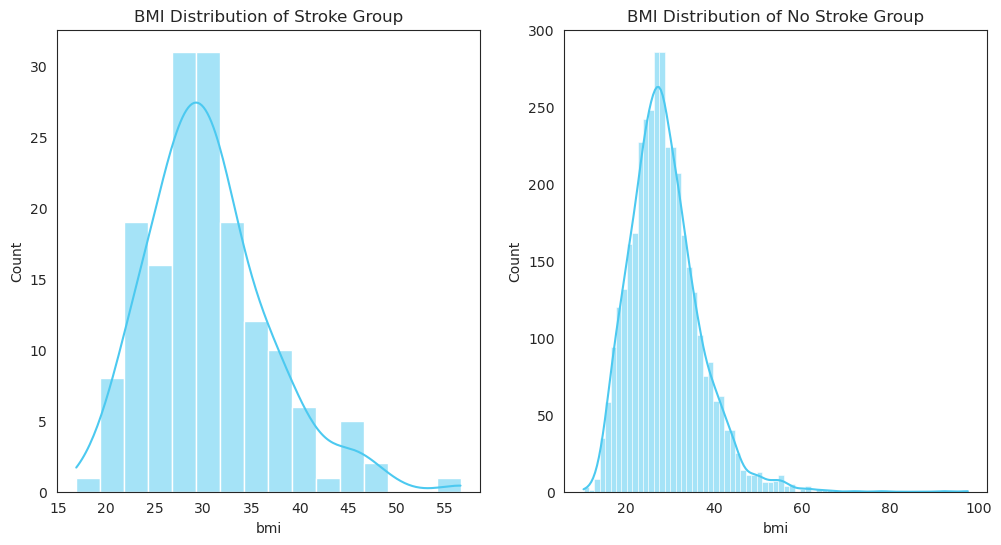


Levene's test for homogeneity of variance:
Statistic: 8.0604
p-value: 0.0045

Welch t-test result: TtestResult(statistic=3.3579208257247677, pvalue=0.0009550626318586854, df=183.27715773206563)

Confidence interval for stroke group: (29.601312864139306, 31.587576024749577)
Confidence interval for no stroke group: (28.59475023557796, 29.105356260694673)


In [36]:
stroke_group = train_data[train_data['stroke'] == 1]['bmi'].dropna()
no_stroke_group = train_data[train_data['stroke'] == 0]['bmi'].dropna()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(stroke_group, kde=True, color='#4CC9F0')
plt.title('BMI Distribution of Stroke Group')

plt.subplot(1, 2, 2)
sns.histplot(no_stroke_group, kde=True, color='#4CC9F0')
plt.title('BMI Distribution of No Stroke Group')

plt.show()

levene_test = stats.levene(stroke_group, no_stroke_group)
print("\nLevene's test for homogeneity of variance:")
print(f'Statistic: {levene_test.statistic:.4f}')
print(f'p-value: {levene_test.pvalue:.4f}')

t_test_result = stats.ttest_ind(stroke_group, no_stroke_group, equal_var=False)
print(f'\nWelch t-test result: {t_test_result}')

confidence_level = 0.95

confidence_interval_stroke = stats.t.interval(
    confidence_level, 
    len(stroke_group) - 1, 
    loc=np.mean(stroke_group), 
    scale=stats.sem(stroke_group)
)

confidence_interval_no_stroke = stats.t.interval(
    confidence_level, 
    len(no_stroke_group) - 1, 
    loc=np.mean(no_stroke_group), 
    scale=stats.sem(no_stroke_group)
)

print(f'\nConfidence interval for stroke group: {confidence_interval_stroke}')
print(f'Confidence interval for no stroke group: {confidence_interval_no_stroke}')


We don't know the population's standard deviation. Both groups failed Levene's normality test, so we will to the Welch's t-test again.

The t-statistic is 2.80 to 2 d.p. The p-value is well below our 95% significance level. The confidence intervals do not overlap, further supporting the conclusion that there is a significant difference in bmi levels between the two groups.

### Handling and imputing missing data before ML

#### Handling missing smoking values

In [37]:
from sklearn.ensemble import RandomForestClassifier

def convert_smoking_status_to_binary(data, columns):
    for col in columns:
        data[col] = data[col].astype(int)

def modify_data_based_on_age(data, age_threshold, unknown_col, never_smoked_col):
    unknown_count = data[unknown_col].sum()
    print(f"Number of values in the {unknown_col} column: {unknown_count}")

    modified_entries = data.loc[data['age'] < age_threshold, unknown_col].sum()
    data.loc[data['age'] < age_threshold, unknown_col] = 0
    data.loc[data['age'] < age_threshold, never_smoked_col] = 1
    print(f"Number of entries modified: {modified_entries}")

def train_and_predict(train_data, test_data, smoking_status_columns):
    train_smoking = train_data[train_data['smoking_status_Unknown'] == 0]
    target_smoking = train_smoking[smoking_status_columns[1:]]  # Exclude 'smoking_status_Unknown'
    train_smoking = train_smoking.drop(columns=smoking_status_columns)

    model = RandomForestClassifier()
    model.fit(train_smoking, target_smoking)

    missing_smoking_train = train_data[train_data['smoking_status_Unknown'] == 1]
    predicted_smoking_train = model.predict(missing_smoking_train.drop(columns=smoking_status_columns))
    train_data.loc[train_data['smoking_status_Unknown'] == 1, smoking_status_columns[1:]] = predicted_smoking_train

    missing_smoking_test = test_data[test_data['smoking_status_Unknown'] == 1]
    predicted_smoking_test = model.predict(missing_smoking_test.drop(columns=smoking_status_columns))
    test_data.loc[test_data['smoking_status_Unknown'] == 1, smoking_status_columns[1:]] = predicted_smoking_test

    return predicted_smoking_train, predicted_smoking_test

# Define smoking status columns
smoking_status_columns = ['smoking_status_Unknown', 'smoking_status_formerly smoked', 
                          'smoking_status_never smoked', 'smoking_status_smokes']

# Convert all smoking status columns to binary (0 and 1)
convert_smoking_status_to_binary(train_data, smoking_status_columns)
convert_smoking_status_to_binary(test_data, smoking_status_columns)

# Modify train and test data
modify_data_based_on_age(train_data, 10, 'smoking_status_Unknown', 'smoking_status_never smoked')
modify_data_based_on_age(test_data, 10, 'smoking_status_Unknown', 'smoking_status_never smoked')

# Train the model and predict missing values
predicted_smoking_train, predicted_smoking_test = train_and_predict(train_data, test_data, smoking_status_columns)

# Drop the smoking_status_Unknown column
train_data = train_data.drop(columns=['smoking_status_Unknown'])
test_data = test_data.drop(columns=['smoking_status_Unknown'])

# Print average predicted values for verification
average_predicted_smoking_train = np.mean(predicted_smoking_train, axis=0)
print(f"Average of the predicted smoking status values in train data: {average_predicted_smoking_train}")

average_predicted_smoking_test = np.mean(predicted_smoking_test, axis=0)
print(f"Average of the predicted smoking status values in test data: {average_predicted_smoking_test}")

Number of values in the smoking_status_Unknown column: 1247
Number of entries modified: 384
Number of values in the smoking_status_Unknown column: 297
Number of entries modified: 88
Average of the predicted smoking status values in train data: [0.06373117 0.58053302 0.03476246]
Average of the predicted smoking status values in test data: [0.02870813 0.66507177 0.03349282]


All entries of under 10 years old to be mark as never smoked. We have use a random forest model to assign the rest of the values.

#### Handlin missing BMI values

In [38]:
# Separate the train data into training and target sets
train_bmi = train_data.dropna(subset=['bmi'])
target_bmi = train_bmi['bmi']
train_bmi = train_bmi.drop(columns=['bmi'])

# Train the model
model = RandomForestRegressor()
model.fit(train_bmi, target_bmi)

missing_bmi = train_data[train_data['bmi'].isna()]
predicted_bmi = model.predict(missing_bmi.drop(columns=['bmi']))

train_data.loc[train_data['bmi'].isna(), 'bmi'] = predicted_bmi

average_predicted_bmi = np.mean(predicted_bmi)
print(f"Average of the predicted BMI for train_test values: {average_predicted_bmi}")

Average of the predicted BMI for train_test values: 30.731111764705876


In [39]:
missing_bmi_test = test_data[test_data['bmi'].isna()]

# Drop the 'bmi' column as we did for the training set
predicted_bmi_test = model.predict(missing_bmi_test.drop(columns=['bmi']))

# Fill the missing bmi values in the test data
test_data.loc[test_data['bmi'].isna(), 'bmi'] = predicted_bmi_test

# Calculate and print the average of the predicted BMI values in the test data
average_predicted_bmi_test = np.mean(predicted_bmi_test)

We used a random forest to imputate the missing BMI values.

#### Assigning the mean to the remaining missing entries in the 'bmi' variable

In [40]:
test_data['bmi'].isnull().sum()

0

We are going to divide the bmi data in two categories, children and adults, since as the NHS and other sources, the calculation differs. Once we have the mean for each group, we will add it to the missing entries.

In [41]:
mean_bmi_0_17 = stroke_prediction_df[stroke_prediction_df['age'] < 18]['bmi'].mean()
mean_bmi_18_plus = stroke_prediction_df[stroke_prediction_df['age'] >= 18]['bmi'].mean()

stroke_prediction_df.loc[(stroke_prediction_df['age'] < 18) & (stroke_prediction_df['bmi'].isnull()), 'bmi'] = mean_bmi_0_17
stroke_prediction_df.loc[(stroke_prediction_df['age'] >= 18) & (stroke_prediction_df['bmi'].isnull()), 'bmi'] = mean_bmi_18_plus

In [42]:
stroke_prediction_df['bmi'].isnull().sum()

0

## Logistic Regression

In [43]:
train_data.head(1)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_Male,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
845,48.0,0,0,69.21,33.1,0,0,True,True,False,False,True,False,False,0,1,0


Given the binary nature of the dependent variable (patient suffering a stroke or not) and our previous analysis, logistic regression seems to be a good way of predicting the outcome we are interested in. We will balance the class-weight, since patients who didn't suffer a stroke are much more common.

Accuracy: 0.7397260273972602
Precision: 0.14
Recall: 0.84
F1-score: 0.24
ROC AUC: 0.7872839506172838


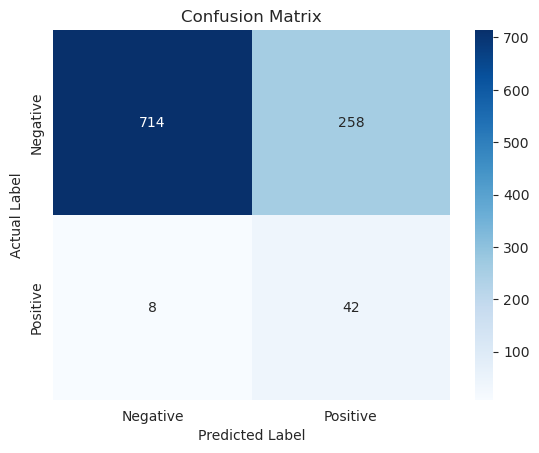

In [44]:
# Define features
features = [
    'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 
    'is_Male', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Govt_job', 
    'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
    'work_type_children', 'smoking_status_formerly smoked', 
    'smoking_status_never smoked', 'smoking_status_smokes'
]

target = 'stroke'

# Split the data into training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

X_train_sqrt = np.sqrt(X_train)
X_test_sqrt = np.sqrt(X_test)

# Train the logistic regression model
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model.fit(X_train_sqrt, y_train)

# Make predictions
y_pred = model.predict(X_test_sqrt)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Due the nature of the object of the study, we can argue that it's more better to overpredict the patients that will suffer a stroke. Therefore, we have lowered the thresold to predict strokes.

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.4s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifie

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END 

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.5s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END class

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END classifier__C=

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.4s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifie

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.8s
[CV] END classifier__C=0.0001, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.5s
[CV] END classifier__C=0.0001, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END class

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.9s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.5s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocesso

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.8s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.1s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, 

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.3s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.9s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.6s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num_

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lib

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__so

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, 

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   0.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.7s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.7s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=libl

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.9s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, prepr

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.1s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.8s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__p

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.2s
[CV] END classifier__C=0.012742749857031334, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   1.8s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   2.6s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num_

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.1s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.6s
[CV] END classifier__C=0.03359818286283781, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.3s
[CV] END classifier__C=0.08858667904100823, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__p

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.4s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.2s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.6s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.3s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly_

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   4.5s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.5s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.5s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.3s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.2s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.1s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.5s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.2s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.7s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.2s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.0s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   4.1s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=4.281332398719396, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   2.0s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   3.4s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   4.0s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   4.8s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__pol

[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   3.2s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.2s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.5s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.1s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.0s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.1s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   2.1s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, prep

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=4.281332398719396, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.8s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__poly__degree=2; total time=   2.9s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.5s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.1s
[CV] END classifier__C=4.281332398719396, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, preprocessor__num__po

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.4s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, preprocessor__num__poly__degree=1; total time=   1.3s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=1; total time=   1.0s
[CV] END classifier__C=11.288378916846883, classifier__class_weight=None, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear, preprocessor__num__poly__degree=2; total time=   1.9s
[CV] END classifier__C=29.763514416313132, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear, preprocess

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag

Best parameters: {'classifier__C': 0.08858667904100823, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'preprocessor__num__poly__degree': 1}
Best cross-validation score: 0.6604193155871412
Accuracy: 0.9002
Precision: 0.2636
Recall: 0.5800
F1-score: 0.3625
ROC AUC: 0.8450
Confusion Matrix:
[[891  81]
 [ 21  29]]


/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


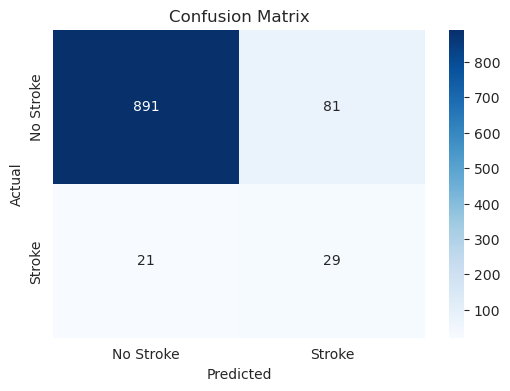

['best_stroke_prediction_model.joblib']

In [67]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = [col for col in features if col not in numerical_features]

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False))
])

pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('pass', 'passthrough', categorical_features)
        ])),
    ('feature_selector', RFECV(
        estimator=LogisticRegression(random_state=42, solver='liblinear'),
        step=1,
        cv=StratifiedKFold(5),
        scoring='roc_auc'
    )),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid = {
    'preprocessor__num__poly__degree': [1, 2],  # Polynomial degree
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-4, 4, 20),  # Regularization strength
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced', None],
    'classifier__max_iter': [1000]
}

# Custom scorer that combines multiple metrics
def custom_scorer(y_true, y_pred_proba):
    y_pred = (y_pred_proba >= 0.5).astype(int)
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    return 0.7 * auc + 0.3 * f1  # Weighted combination

# Create GridSearchCV with custom scorer
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring=make_scorer(custom_scorer, needs_proba=True),
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Find optimal threshold using precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)
optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]

# Make predictions with optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model
results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

# Print results
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'], 
            yticklabels=['No Stroke', 'Stroke'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Save the model and results
joblib.dump(best_model, 'best_stroke_prediction_model.joblib')


Our logistic regression model shows an area under the curve (AUC) of 0.845, indicating good discrimination ability. However, we might be interested in getting more true positives, due to the nature of the data we are studying, so we could try lowering the threshold and the expense of lowering precision too (and therefore overestimating true positives).

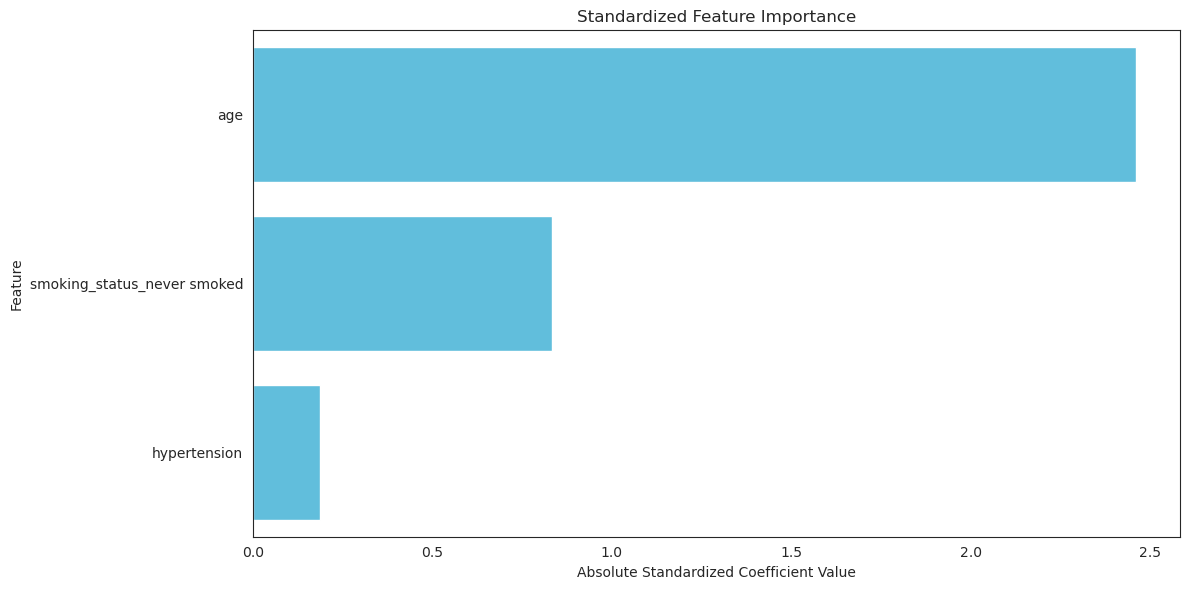

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

model_l1_scaled = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)
model_l1_scaled.fit(X_train_scaled, y_train)

standardized_importance = pd.DataFrame({
    'Feature': selected_features,
    'Standardized_Coefficient': abs(model_l1_scaled.coef_[0])
})
standardized_importance = standardized_importance.sort_values('Standardized_Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=standardized_importance, x='Standardized_Coefficient', y='Feature', palette=palette)
plt.title('Standardized Feature Importance')
plt.xlabel('Absolute Standardized Coefficient Value')
plt.tight_layout()
plt.show()

### Random Forest

Fitting 5 folds for each of 351 candidates, totalling 1755 fits
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=200, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=250, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=400, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=100, random_state=42; total time=   0.3s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=200, random_state=42; total time= 

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=100, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=100, random_state=42; total time=   0.5s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=250, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=350, random_state=42; total time=   0.9s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=450, random_state=42; total time=   1.1s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=300, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=400, random_state=42; total time=   1.1s
[CV] END class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=50, random_state=42; total time=   0.2s
[CV] END class_weight=balanced, max_depth=3, max_features

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=150, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=200, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=200, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=250, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=250, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=250, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=450, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50, random_state=42; total time=   0.2s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=150, random_state=42; total time=   0.4s
[CV] END class_weight=balanced, max_depth=2, max_features=

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=150, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=150, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=200, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=200, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=250, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features

[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=200, random_state=42; total time=   0.7s
[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=200, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=400, random_state=42; total time=   1.9s
[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=450, random_state=42; total time=   2.1s
[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=450, random_state=42; total time=   1.6s
[CV] END class_weight=balanced, max_depth=6, max_features=sqrt, n_estimators=450, random_state=42; total time=   1.9s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=350, random_state=42; total time=   1.4s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=450, random_state=42; total time=   1.9s
[CV] END class_weight=balanced, max_depth=7, max_feature

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=400, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50, random_state=42; total time=   0.2s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=200, random_state=42; total time=   0.5s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=300, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=400, random_state=42; total time=   1.0s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=100, random_state=42; total time=   0.3s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=150, random_state=42; total time=   0.4s
[CV] END class_weight=balanced, max_depth=2, max_features=

[CV] END class_weight=balanced, max_depth=2, max_features=auto, n_estimators=150, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=200, random_state=42; total time=   0.6s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=300, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=400, random_state=42; total time=   1.2s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=200, random_state=42; total time=   0.5s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=300, random_state=42; total time=   0.8s
[CV] END class_weight=balanced, max_depth=2, max_features=log2, n_estimators=400, random_state=42; total time=   1.2s
[CV] END class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=150, random_state=42; total time=   0.5s
[CV] END class_weight=balanced, max_depth=3, max_feature

[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=300, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=350, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=400, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=400, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=400, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_feature

[CV] END class_weight=balanced, max_depth=7, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=400, random_state=42; total time=   1.6s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=50, random_state=42; total time=   0.2s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=100, random_state=42; total time=   0.4s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=150, random_state=42; total time=   0.6s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=250, random_state=42; total time=   1.1s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=350, random_state=42; total time=   1.4s
[CV] END class_weight=balanced, max_depth=8, max_features=auto, n_estimators=50, random_state=42; total time=   0.0s
[CV] END class_weight=balanced, max_depth=8, max_features=a

[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=150, random_state=42; total time=   0.6s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=150, random_state=42; total time=   0.6s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=200, random_state=42; total time=   0.9s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=300, random_state=42; total time=   1.3s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, n_estimators=350, random_state=42; total time=   1.6s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=50, random_state=42; total time=   0.2s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=100, random_state=42; total time=   0.4s
[CV] END class_weight=balanced, max_depth=7, max_features=log2, n_estimators=150, random_state=42; total time=   0.6s
[CV] END class_weight=balanced, max_depth=7, max_features

/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
585 fits failed out of a total of 1755.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
238 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/jean/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/jean/

Best Parameters: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 250, 'random_state': 42}
Random Forest Accuracy: 0.7778864970645792
Random Forest Precision: 0.15294117647058825
Random Forest Recall: 0.78
Random Forest F1-score: 0.25573770491803277
Random Forest ROC AUC: 0.778888888888889


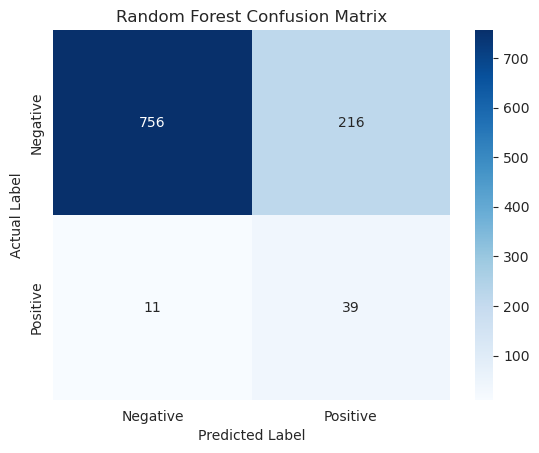

In [47]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(50, 500, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': range(2, 15),
    'class_weight': ['balanced'],
    'random_state': [42]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with scoring='f1'
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest F1-score:", f1_rf)
print("Random Forest ROC AUC:", roc_auc_rf)

# Plot the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [48]:
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                           Feature    Importance
3                avg_glucose_level  2.741576e-01
0                              age  2.371815e-01
4                              bmi  2.332441e-01
7             Residence_type_Urban  3.369447e-02
5                          is_Male  3.090671e-02
1                     hypertension  2.788142e-02
10               work_type_Private  2.239499e-02
14     smoking_status_never smoked  2.229836e-02
2                    heart_disease  2.223371e-02
6                 ever_married_Yes  2.211811e-02
13  smoking_status_formerly smoked  2.114089e-02
11         work_type_Self-employed  1.965856e-02
15           smoking_status_smokes  1.731409e-02
8               work_type_Govt_job  1.495641e-02
12              work_type_children  8.187823e-04
9           work_type_Never_worked  3.172688e-07


Our random forest model's 3 main metrics are in line with our EDA, being glucose, age and bmi the 3 most important features.